In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sklearn
import pickle
model_pkl_file = "celeb_classifier_model.pkl"

from model import get_model
from utills import rearrange, load_data, extract_piece, swap_piece

In [3]:
base_path = 'data/celeb_2x2/'

## Defining essential variables

In [4]:
cuts = 2    
channel = 3
im_size = 200

## Load pretrained model, you can download the model from [here](https://www.floydhub.com/shivaverma/workspaces/run_LEzD4uEtzqggKf5p2risz7NE)

In [28]:
# model = keras.models.load_model('model/jigsaw.model')

## Or train from scratch model

In [11]:
# model = get_model()

In [12]:
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam)

In [13]:
x_val,   y_val   = load_data(base_path, 'valid')
x_train, y_train = load_data(base_path, 'train')

KeyboardInterrupt: 

In [8]:
model.fit(x_train, y_train, batch_size=64, epochs=1, validation_data=(x_val, y_val))

NameError: name 'x_train' is not defined

In [8]:

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\flatten
......vars
...layers\reshape
......vars
...layers\time_distributed
......vars
...layers\time_distributed\layer
......vars
...layers\time_distributed_1
......vars
...layers\time_distributed_10
......vars
...layers\time_distributed_10\layer
......vars
.........0
.........1
...layers\time_distributed_11
......vars
...layers\time_distributed_11\layer
......vars
.........0
.........1
.........2
.........3
...layers\time_distributed_12
......vars
...layers\time_distributed_12\layer
......vars
...layers\time_distributed_1\layer
.....

## Loading test data

In [5]:
x_test, y_test = load_data(base_path, 'test')

In [6]:
from IPython.display import clear_output

## Testing indivisual Image

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-11-18 20:31:46        10683
metadata.json                                  2023-11-18 20:31:46           64
variables.h5                                   2023-11-18 20:31:46     96774536
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\activation
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\flatten
......vars
...layers\reshape
......vars
...layers\time_distributed
......vars
...layers\time_distributed\layer
......vars
...layers\time_distributed_1
......vars
...layers\time_distri

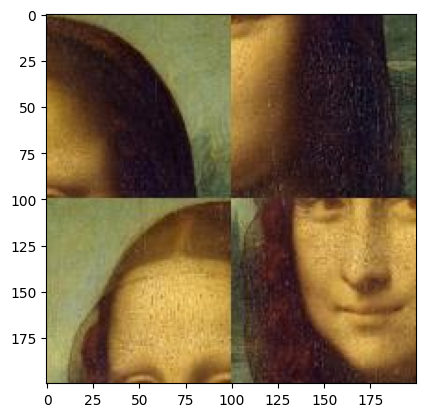

1/1 [==============================] - 0s 205ms/step


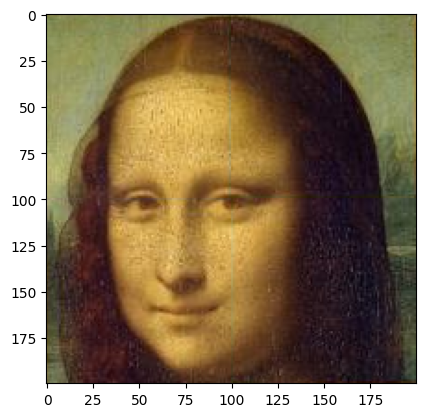

1/1 [==============================] - 0s 31ms/step
Accuracy on index 701: 100.0%


In [19]:
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)
im = 701

plt.imshow(x_test[im].astype('float64')+.5)
plt.show()

inp = np.expand_dims(extract_piece(x_test[im]), axis=0)
out = model.predict(inp)[0]
out = np.argmax(out, axis=1)
rearrange(np.array(x_test[im])+.5, out)

inp = np.expand_dims(extract_piece(x_test[im]), axis=0)

out = model.predict(inp)[0]
predicted_label = np.argmax(out, axis=1)

# Reshape the true label for comparison
true_label = y_test[im].reshape(cuts*cuts)

# Compare predicted label with true label to calculate accuracy for each position
solved = sum(1 for pred, true in zip(predicted_label, true_label) if pred == true)

accuracy = solved / len(true_label) * 100
print(f"Accuracy on index {im}: {round(accuracy, 2)}%")

## Testing whole test set

In [9]:
solved = 0
x_test_proc = []

for i in x_test:
    x_test_proc.append(extract_piece(i))
    
x_test_proc = np.array(x_test_proc) 
out = model.predict(x_test_proc)

for i in range(len(out)):
    pos = np.argmax(out[i], axis=1)
    if list(pos) == list(y_test[i].reshape(cuts*cuts)):
        solved += 1

print("Accuracy on {} samples: {}%".format(len(out), round((solved/i)*100, 2)))

23/23 [==============================] - 2s 84ms/step
Accuracy on 710 samples: 93.09%


## Correct prediction percentage for each position

In [10]:
all_val = []

for i in range(len(out)):

    pos = np.argmax(out[i], axis=1)
    val = (pos==y_test[i].reshape(cuts*cuts)).astype('int')    
    all_val.append(val)

all_val = np.array(all_val)
[round(i, 2) for i in (np.sum(all_val, axis=0)/len(out))*100]

[95.35, 95.21, 95.77, 95.77]

In [11]:
overall_accuracy = (solved / len(out)) * 100
print("Overall Accuracy: {}%".format(round(overall_accuracy, 2)))


Overall Accuracy: 92.96%


In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.reshape(-1), np.concatenate(out).argmax(axis=1))
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[674   8  24   4]
 [ 11 674   5  20]
 [ 13   9 686   2]
 [  8  16   7 679]]


In [13]:
from sklearn.metrics import classification_report
report = classification_report(y_test.reshape(-1), np.concatenate(out).argmax(axis=1))
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       710
           1       0.95      0.95      0.95       710
           2       0.95      0.97      0.96       710
           3       0.96      0.96      0.96       710

    accuracy                           0.96      2840
   macro avg       0.96      0.96      0.96      2840
weighted avg       0.96      0.96      0.96      2840



In [14]:
per_class_accuracy = (np.sum(all_val, axis=0) / len(out)) * 100
for i, acc in enumerate(per_class_accuracy):
    print("Accuracy for Position {}: {}%".format(i, round(acc, 2)))


Accuracy for Position 0: 95.35%
Accuracy for Position 1: 95.21%
Accuracy for Position 2: 95.77%
Accuracy for Position 3: 95.77%
